In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [ ]:
# Load the dataset
data_path = '/kaggle/input/pima-indians-diabetes-database/diabetes.csv'  # Update the path if needed
df = pd.read_csv(data_path)

In [ ]:
# Basic statistics and info
print("\nDataset Information:")
print(df.info())

In [ ]:
# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())


In [ ]:
# Fill missing values with the median of each column
df.fillna(df.median(), inplace=True)


In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Replace zeros in specific columns with NaN for imputation
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_fix:
    df[col] = df[col].replace(0, np.nan)

In [ ]:
# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
df[columns_to_fix] = imputer.fit_transform(df[columns_to_fix])

In [ ]:
# Add interaction feature
df['Glucose_BMI'] = df['Glucose'] * df['BMI']

In [ ]:
# Add age group feature
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=[1, 2, 3, 4, 5, 6])


In [ ]:
# Splitting the data into features and target
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']  # Target

In [ ]:
# Standardizing numerical columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Check for NaNs after scaling
if np.isnan(X_scaled).any():
    print("NaNs detected after scaling! Fixing them...")
    X_scaled = np.nan_to_num(X_scaled)


In [ ]:
# Dimensionality reduction using PCA (optional for visualization)
pca = PCA(n_components=8)  # Retain 8 components
X_pca = pca.fit_transform(X_scaled)


In [ ]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Build a pipeline with a Random Forest Classifier
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Scale data
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
 #Hyperparameter grid for optimization
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]}

In [ ]:
# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print("\nBest Model Parameters:")
print(grid_search.best_params_)

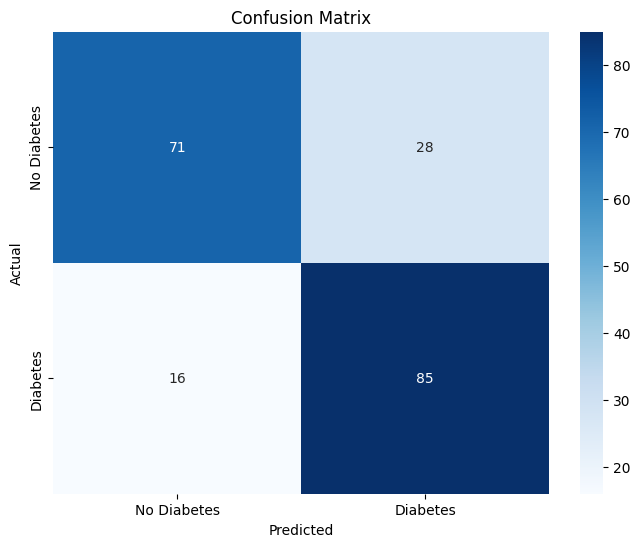

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define y_pred by thresholding the predicted probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



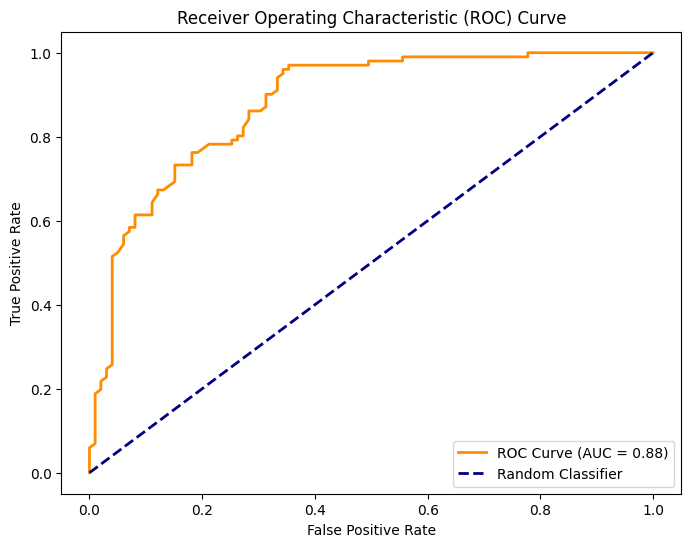

In [25]:
# Get the predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [26]:
print(f"\nROC-AUC Score: {roc_auc:.2f}")


ROC-AUC Score: 0.88
